#Set environment

## Install necesary dependencies

In [1]:
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!pip install .
%cd examples/text_to_image
!pip install -r requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 26436, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 26436 (delta 226), reused 278 (delta 170), pack-reused 26078
Receiving objects: 100% (26436/26436), 32.16 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (19167/19167), done.
/content/diffusers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.3 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.17.0.dev0-py3-none-any.whl size=965530 sha256=8bc9e737e0581da89cec0b7f9acd2bd4ae15dec2ceab56fa66dd1d043776a9a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-dw8jc40m/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9

In [2]:
!accelerate config default

2023-05-14 20:36:27.330234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Log in into hugginface account

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Your token has been saved in your configured git cred

# Train with LORA

In [6]:
MODEL_NAME="CompVis/stable-diffusion-v1-4"
dataset_name="lambdalabs/pokemon-blip-captions"

!accelerate launch --mixed_precision="fp16" train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$dataset_name \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=50 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --seed=0 \
  --validation_prompt="a drawing of a green pokemon with red eyes" \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="sd-pokemon-model"

2023-05-14 20:37:26.751910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-14 20:37:32.401098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/14/2023 20:37:36 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'prediction_type', 'dynamic_thresholding_ratio', 'sample_max_value', 'variance_type', 'thresholding', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'norm_num_groups'} was not found in config. Values will be initialized to default values.
{'resnet_out_scale_factor', 'encoder_hid_dim', 'conv_out_kernel', 'mid_block_only_cros

# Inference LORA

In [8]:
from typing import Any
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import PIL
import numpy as np
import matplotlib.pyplot as plt


class PokemonPipeline:
    """A class for performing image generation using a Pokemon model."""

    def __init__(self, 
                 model_base: str="CompVis/stable-diffusion-v1-4",
                 model_trained: str="sd-pokemon-model",
                 device: str="cuda"
                 ) -> None:
        """
        Initialize the PokemonPipeline instance.

        Args:
            model_base (str): The base model name or path.
            model_trained (str): The fine-tunned model path.
            device (str): The device to use for computation.

        """
        self.model = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
        self.model.scheduler = DPMSolverMultistepScheduler.from_config(self.model.scheduler.config)

        self.model.unet.load_attn_procs(model_trained)
        self.model.to(device)

    def __call__(self, prompt: str, scale: np.float16=0.5, num_inference_steps: int=25, guidance_scale: float=7.5) -> PIL.Image:
        """
        Generate an image using the Pokemon model.

        Args:
            prompt (str): The text prompt to generate an image for.
            scale (np.float16): The scale of the cross-attention image.
            num_inference_steps (int): The number of inference steps to perform.
            guidance_scale (float): The scale of guidance for diffusion models.

        Returns:
            PIL.Image.Image: The generated image.
        """
        return self.model(
            prompt=prompt, 
            num_inference_steps=num_inference_steps, 
            guidance_scale=guidance_scale, 
            cross_attention_kwargs={"scale": scale}
            ).images[0]
    

In [9]:
pipe = PokemonPipeline(
    model_base="CompVis/stable-diffusion-v1-4",
    model_trained="/content/gdrive/MyDrive/AI_dreams/sd-pokemon-model"
    )

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

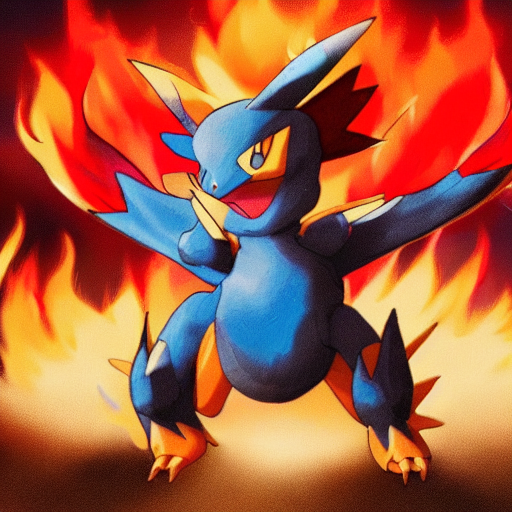

In [10]:
image = pipe(
        "A pokemon with blue eyes, red skin, winds and fire type", scale=0.5
    )

image

  0%|          | 0/50 [00:00<?, ?it/s]

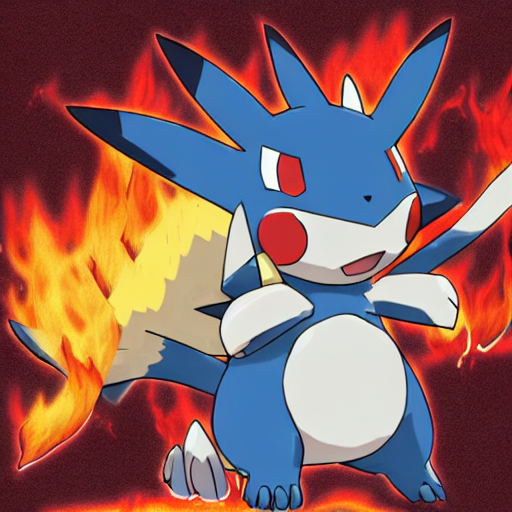

In [30]:
image = pipe(
        "A pokemon with blue eyes, red skin, winds and fire type", scale=0.5, num_inference_steps=50
    )

image